# Gram method

This notebook aims at evaluating the **gram method**.

The method consists in computing the Gram matrices of several layers to evaluate the channel-wise correlation of internal features. A score is built by computing these correlations for a new input and evaluating their deviation from regular correlations values computed on the in-distribution dataset.

**Important Disclaimer**: Taking the statistics of min/max deviation,
as in the paper raises some problems.

The method often yields a score of zero for some tasks.
This is expected since the min/max among the samples of a random
variable becomes more and more extreme with the sample
size. As a result, computing the min/max over the training set is likely to produce
min/max values that are so extreme that none of the in distribution correlations of
the validation set goes beyond these threshold. The worst is that a significant
part of ood data does not exceed the thresholds either. This can be aleviated by
computing the min/max over a limited number of sample. However, it is
counter-intuitive and, in our opinion, not desirable: adding
some more information should only improve a method.

Hence, we decided to replace the min/max by the q / 1-q quantile, with q a new
parameter of the method. Specifically, instead of the deviation as defined in
eq. 3 of the paper, we use the definition
$$
\delta(t_q, t_{1-q}, value) =
\begin{cases}
    0 & \text{if} \; t_q \leq value \leq t_{1-q} \\
    \frac{t_q - value}{|t_q|} & \text{if } value < t_q,  \\
    \frac{value - t_{1-q}}{|t_q|} & \text{if } value > t_{1-q}
\end{cases}
$$
With this new deviation, the more point we add, the more accurate the quantile
becomes. In addition, the method can be made more or less discriminative by toggling
the value of q.

Finally, we found that this approach improved the performance of the baseline in
our experiments.

Here, we focus on a toy convolutional network trained on MNIST[0-4] and a ResNet model
trained on CIFAR-10, respectively challenged on MNIST[5-9] and SVHN OOD datasets.

**Reference**
[Detecting Out-of-Distribution Examples with Gram Matrices](https://proceedings.mlr.press/v119/sastry20a.html), ICML 2020

### Imports


In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np

from oodeel.methods import Gram
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import load_data_handler
from oodeel.utils.torch_training_tools import train_torch_model
from oodeel.aggregator import StdNormalizedAggregator


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## First exp: MNIST[0-4] vs MNIST[5-9]

For this first experiment, we train a toy convolutional network on the MNIST dataset
restricted to digits 0 to 4. After fitting the train subset of this dataset to the Gram
method, we will compare the scores returned for MNIST[0-4] (in-distrubtion) and
MNIST[5-9] (out-of-distribution) test subsets.


### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote the core class
> `OODBaseDetector`.


In [3]:
# === Load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- Load train/test MNIST dataset
data_handler = load_data_handler("torch")

# 1- Load train/test MNIST dataset
ds_train = data_handler.load_dataset(
    "MNIST", load_kwargs={"root": data_path, "train": True, "download": True}
)
data_test = data_handler.load_dataset(
    "MNIST", load_kwargs={"root": data_path, "train": True, "download": True}
)

# 2- Split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
ds_fit, _ = data_handler.split_by_class(ds_train, in_labels)
ds_in, ds_out = data_handler.split_by_class(data_test, in_labels)


# 3- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    inputs["input"] = inputs["input"].float() / 255.0
    return inputs


ds_fit = data_handler.prepare(
    ds_fit, batch_size, preprocess_fn, shuffle=True, columns=["input", "label"]
)
ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["input", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["input", "label"]
)

### Model training

Now let's train a simple model on MNIST[0-4] using `train_torch_model` function.


Test accuracy:	0.994084

=== Penultimate features viz ===


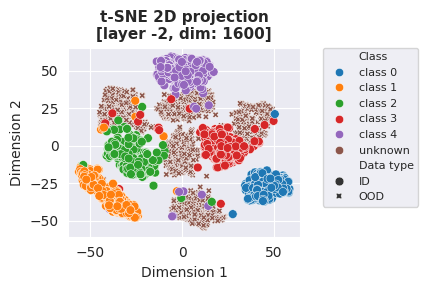

In [ ]:
# === Train / Load model ===
# model path
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4")

try:
    # if the model exists, load it
    model = torch.load(
        os.path.join(model_path_mnist_04, "best.pt"), weights_only=False
    ).to(device)
except OSError:
    # else, train a new model
    train_config = {
        "model": "toy_mlp",
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,
    }
    model = train_torch_model(ds_fit, **train_config).to(device)
    clear_output()

# evaluate model
model.eval()
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### Gram score

We now fit a Gram detector with MNIST[0-4] train dataset, and compare OOD scores
returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


In [ ]:
# === gram scores ===
gram = Gram(quantile=0.01, aggregator=StdNormalizedAggregator())
gram.fit(model, ds_fit, feature_layers_id=["pool1", "pool2"])
scores_in, _ = gram.score(ds_in)
scores_out, _ = gram.score(ds_out)


# Since many scores are equal to 0, we add a random noise to avoid bugs
# in Auroc and TPR computation.
scores_in += np.random.random_sample(size=scores_in.shape) * 10e-6
scores_out += np.random.random_sample(size=scores_out.shape) * 10e-6

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

=== Metrics ===
auroc      0.715722
fpr95tpr   0.878383



=== Plots ===


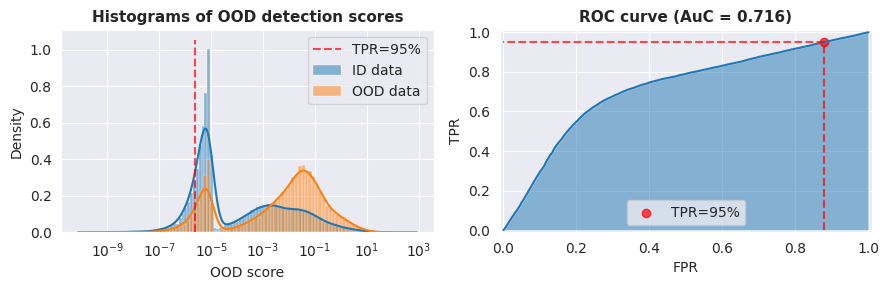

In [7]:
print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

## Second exp: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN**
(out-of-distribution dataset).


### Data loading

- In-distribution data: CIFAR-10
- Out-of-distribution data: SVHN


In [8]:
# === Load ID and OOD data ===
batch_size = 128

data_handler = load_data_handler("torch")

# 1a- Load in-distribution dataset: CIFAR-10
ds_fit = data_handler.load_dataset(
    "CIFAR10", load_kwargs={"root": data_path, "train": True, "download": True}
)
ds_in = data_handler.load_dataset(
    "CIFAR10", load_kwargs={"root": data_path, "train": False, "download": True}
)
# 1b- Load out-of-distribution dataset: SVHN
ds_out = data_handler.load_dataset(
    "SVHN", load_kwargs={"root": data_path, "split": "test", "download": True}
)


# 2- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    """Preprocessing function from
    https://github.com/chenyaofo/pytorch-cifar-models
    """
    inputs["input"] = inputs["input"].float() / 255.0
    inputs["input"] = transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )(inputs["input"])
    return inputs


ds_fit = data_handler.prepare(
    ds_fit, batch_size, preprocess_fn, shuffle=True, columns=["input", "label"]
)
ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["input", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["input", "label"]
)

clear_output()

### Model loading

The model is a **ResNet20** pretrained on CIFAR-10 and getting an accuracy score of
92.60%, loaded from
[pytorch-cifar-models](https://github.com/chenyaofo/pytorch-cifar-models) repository.


In [9]:
# === load model ===
# resnet20 pretrained on CIFAR-10
model = torch.hub.load(
    repo_or_dir="chenyaofo/pytorch-cifar-models",
    model="cifar10_resnet20",
    pretrained=True,
    verbose=False,
).to(device)
model.eval()
clear_output()

Test accuracy:	0.925900

=== Penultimate features viz ===


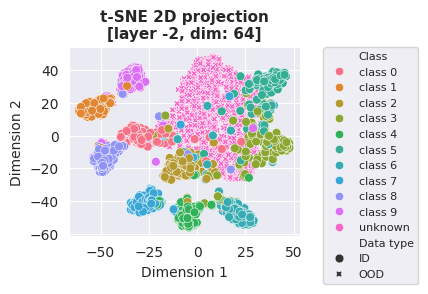

In [10]:
# evaluate model
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### Gram score

We now fit a Gram detector with CIFAR-10 train dataset, and compare OOD scores returned
for CIFAR-10 (ID) and SVHN (OOD) test datasets.


=== Metrics ===
auroc      0.989754
fpr95tpr   0.047300

=== Plots ===


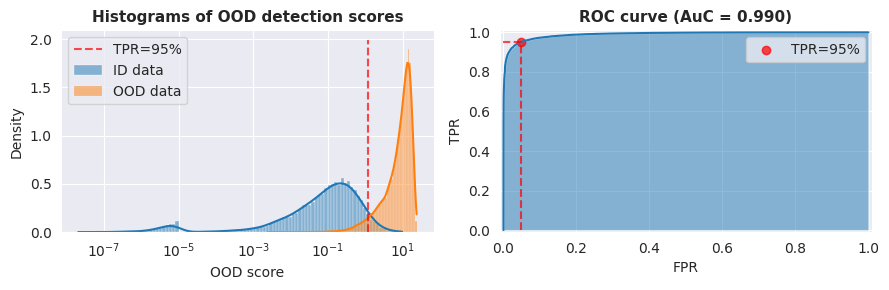

In [ ]:
# === gram scores ===
gram = Gram(quantile=0.01, aggregator=StdNormalizedAggregator())
gram.fit(
    model,
    ds_fit,
    feature_layers_id=[
        "layer1.2.conv2",
        "layer1.2.relu",
        "layer2.2.conv2",
        "layer2.2.relu",
        "layer3.2.conv2",
        "layer3.2.relu",
    ],
    val_split=None,
)
scores_in, _ = gram.score(ds_in)
scores_out, _ = gram.score(ds_out)
scores_in += np.random.random_sample(size=scores_in.shape) * 10e-6
scores_out += np.random.random_sample(size=scores_out.shape) * 10e-6
# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()